In [2]:
import pandas as pd
data = pd.read_csv("Loan_Data.csv")
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
## Identificación de NaNs
data.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
## Función para rellenar los NaN's de acuerdo a la distribución de los datos
data_clean = data.fillna(method = "backfill")
data_clean = data_clean.drop(columns="Loan_ID")
data_clean = data_clean.astype(
    {
        "Credit_History" : "int64",
        "Loan_Amount_Term" : "int64"
    }, copy = False
)
s_f = lambda a: 1 if a == "Y" else 0
data_clean["Loan_Status"] = data_clean["Loan_Status"].apply(s_f)

In [5]:
data_clean

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360,1,Rural,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180,1,Rural,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360,1,Urban,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360,1,Urban,1


In [6]:
data_clean.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [7]:
# Limpieza de datos
for column in data.columns:
  if len(data[column].unique()) < 5:
    print(column)
    print(data[column].unique())

Gender
['Male' 'Female' nan]
Married
['No' 'Yes' nan]
Education
['Graduate' 'Not Graduate']
Self_Employed
['No' 'Yes' nan]
Credit_History
[ 1.  0. nan]
Property_Area
['Urban' 'Rural' 'Semiurban']
Loan_Status
['Y' 'N']


In [8]:
# Preprocesamiento (Keras)
## Librerías
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
## Separación en Train - Test
val_data = data_clean.sample(frac=0.3, random_state=67)
train_data = data_clean.drop(val_data.index)
print(
    "Using %d samples for training and %d for validation"
    % (len(train_data), len(val_data))
)

Using 430 samples for training and 184 for validation


In [10]:
## Dataset objects
def dataframe_to_dataset(dataframe,target):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_data,"Loan_Status")
val_ds = dataframe_to_dataset(val_data,"Loan_Status")
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [11]:
## Input encoding
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [12]:
data_clean.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,1


In [13]:
data_clean.Credit_History.dtype

dtype('int64')

In [14]:
# Categorical features encoded as integers
credit_history = keras.Input(shape=(1,), name="Credit_History", dtype="int64")
loan_amount_term = keras.Input(shape=(1,), name="Loan_Amount_Term", dtype="int64")

# Categorical feature encoded as string
gender = keras.Input(shape=(1,), name="Gender", dtype="string")
married = keras.Input(shape=(1,), name="Married", dtype="string")
dependents = keras.Input(shape=(1,), name="Dependents", dtype="string")
education = keras.Input(shape=(1,), name="Education", dtype="string")
self_employed = keras.Input(shape=(1,), name="Self_Employed", dtype="string")
property_area = keras.Input(shape=(1,), name="Property_Area", dtype="string")

# Numerical features
app_income = keras.Input(shape=(1,), name="ApplicantIncome")
coapp_income = keras.Input(shape=(1,), name="CoapplicantIncome")
loan_amount = keras.Input(shape=(1,), name="LoanAmount")

all_inputs = [
  credit_history,
  loan_amount_term,
  gender,
  married,
  dependents,
  education,
  self_employed,
  property_area,
  app_income,
  coapp_income,
  loan_amount
]

# Integer categorical features
credit_history_encoded = encode_categorical_feature(credit_history, "Credit_History", train_ds, False)
loan_amount_term_encoded = encode_categorical_feature(loan_amount_term, "Loan_Amount_Term", train_ds, False)


# String categorical features
gender_encoded = encode_categorical_feature(gender, "Gender", train_ds, True)
married_encoded = encode_categorical_feature(married, "Married", train_ds, True)
dependents_encoded = encode_categorical_feature(dependents, "Dependents", train_ds, True)
education_encoded = encode_categorical_feature(education, "Education", train_ds, True)
self_employed_encoded = encode_categorical_feature(self_employed, "Self_Employed", train_ds, True)
property_area_encoded = encode_categorical_feature(property_area, "Property_Area", train_ds, True)

# Numerical features
app_income_encoded = encode_numerical_feature(app_income, "ApplicantIncome", train_ds)
coapp_income_encoded = encode_numerical_feature(coapp_income, "CoapplicantIncome", train_ds)
loan_amount_encoded = encode_numerical_feature(loan_amount, "LoanAmount", train_ds)


all_features = layers.concatenate(
    [
        credit_history_encoded,
        loan_amount_term_encoded,
        gender_encoded,
        married_encoded,
        dependents_encoded,
        education_encoded,
        self_employed_encoded,
        property_area_encoded,
        app_income_encoded,
        coapp_income_encoded,
        loan_amount_encoded
  ]
)


In [15]:

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])


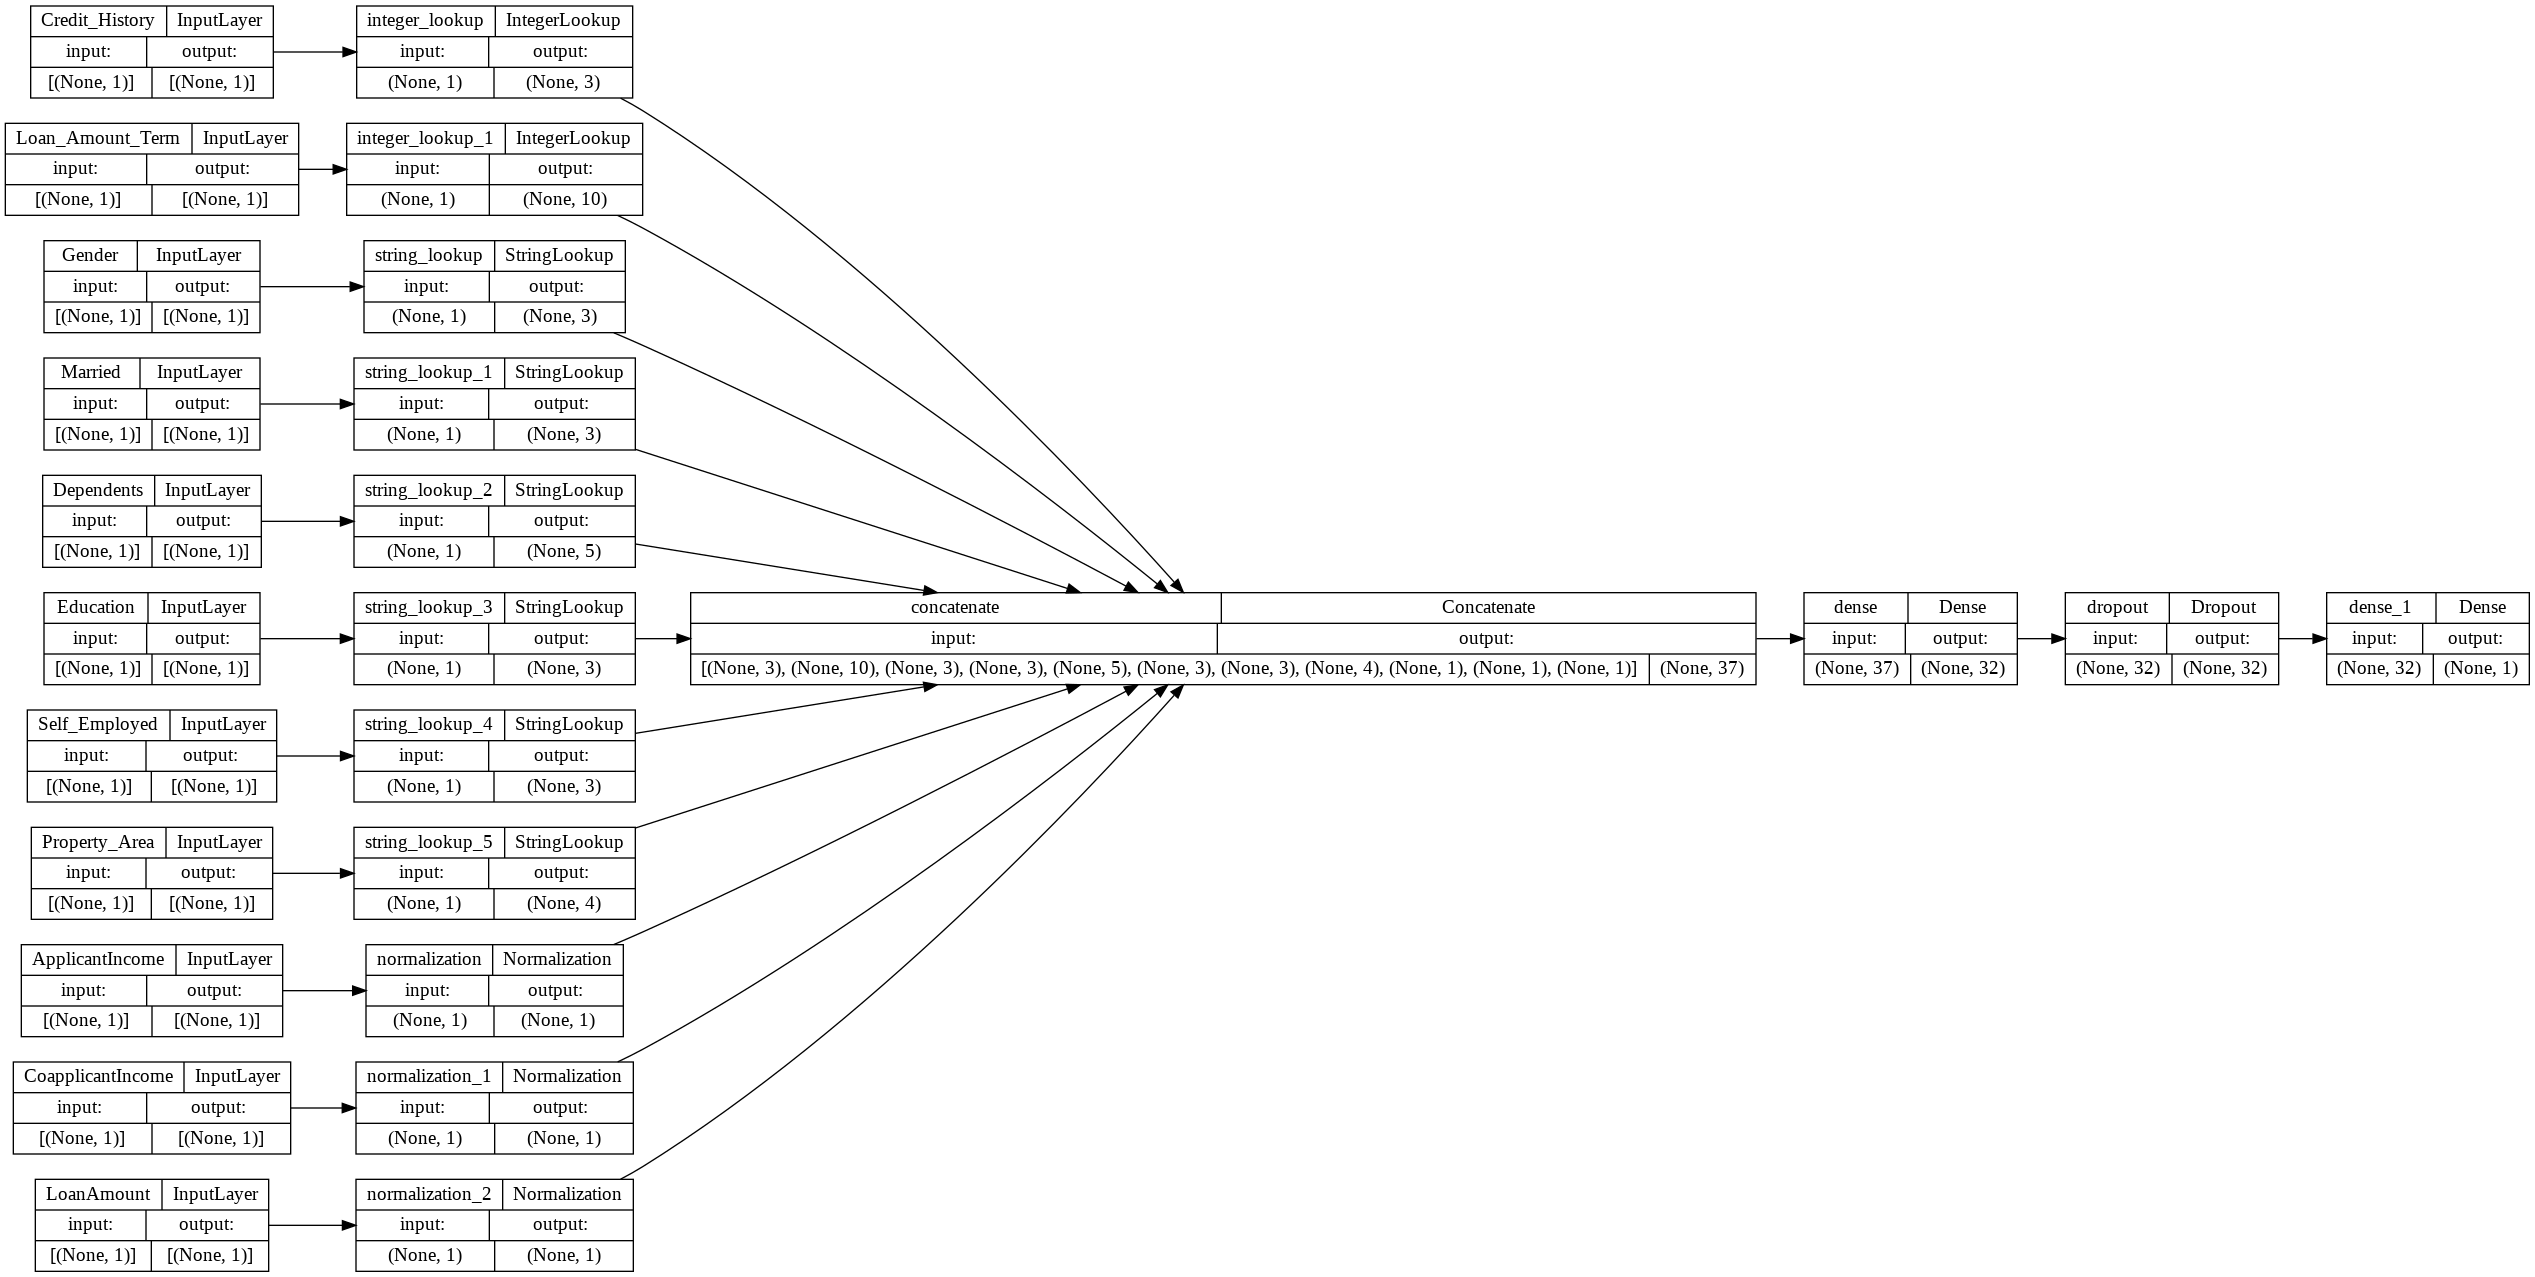

In [16]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [17]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
14/14 [==============================] - 2s 35ms/step - loss: 0.6793 - accuracy: 0.5814 - val_loss: 0.6112 - val_accuracy: 0.7174
Epoch 2/50
14/14 [==============================] - 0s 6ms/step - loss: 0.6690 - accuracy: 0.6186 - val_loss: 0.5895 - val_accuracy: 0.7283
Epoch 3/50
14/14 [==============================] - 0s 6ms/step - loss: 0.6301 - accuracy: 0.6721 - val_loss: 0.5763 - val_accuracy: 0.7283
Epoch 4/50
14/14 [==============================] - 0s 6ms/step - loss: 0.5969 - accuracy: 0.6930 - val_loss: 0.5655 - val_accuracy: 0.7283
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6067 - accuracy: 0.6744 - val_loss: 0.5575 - val_accuracy: 0.7228
Epoch 6/50
14/14 [==============================] - 0s 6ms/step - loss: 0.6229 - accuracy: 0.6837 - val_loss: 0.5504 - val_accuracy: 0.7446
Epoch 7/50
14/14 [==============================] - 0s 6ms/step - loss: 0.5849 - accuracy: 0.7163 - val_loss: 0.5439 - val_accuracy: 0.7609
Epoch 8/50
14/14 [=

In [18]:
data_clean.sample(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
240,Male,Yes,2,Graduate,No,5819,5000.0,120.0,360,1,Rural,1
107,Male,No,0,Not Graduate,No,7333,0.0,120.0,360,1,Rural,0
241,Male,Yes,1,Not Graduate,No,2510,1983.0,140.0,180,1,Urban,0


In [19]:
# Model inference
sample = {
    "Gender": "Male",
    "Married": "No",
    "Dependents": "0",
    "Education": "Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 6300, #Monthly income in USD
    "CoapplicantIncome": 0,
    "LoanAmount": 50, #Loan amount in thousands
    "Loan_Amount_Term": 180, #Term of loan in months
    "Credit_History": 1,
    "Property_Area": "Urban"
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
predictions


1/1 [==============================] - 0s 317ms/step


array([[0.7761836]], dtype=float32)

In [20]:
# Guardar el Modelo
model.save('model',save_format='tf')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('model')
# Verifique que el estado esté preservado
new_predictions = new_model.predict(input_dict)
new_predictions[0][0]

1/1 [==============================] - 0s 277ms/step


0.7761836